# Contributing Factors Analysis

## README

### Overview
This notebook analyses various spatial datasets that may contribute to or correlate with nitrogen dioxide (NO₂) pollution levels in Ethiopia (Addis Ababa) and Iraq (Baghdad). It focuses on road infrastructure, points of interest (POIs), active fire product and population distribution as potential explanatory variables.

### Objective
The goal is to examine the spatial distribution of key human and infrastructural factors that may influence or correlate with nitrogen dioxide (NO₂) pollution levels in urban areas.

### Workflow

1. **Data Acquisition**
   - Downloads datasets from multiple sources:
     - OpenStreetMap (OSM) for roads, industrial facilities, and POIs for [Ethiopia](https://download.geofabrik.de/africa/ethiopia-latest-free.shp.zip) and [Iraq](https://download.geofabrik.de/asia/iraq-latest-free.shp.zip)
     - [WorldPop](https://data.humdata.org/search?q=Spatial+Distribution+of+Population+&ext_search_source=main-nav) for population density
     - [MODIS/VIIRS datasets](https://www.earthdata.nasa.gov/data/instruments/viirs) for fire events
   - Imports country and city boundary shapefiles for Ethiopia and Iraq.

2. **Data Processing**
   - Clips all spatial layers to city-level boundaries. 
   - Aggregates various indicators into uniform mesh grids for spatial comparison.

3. **Visualisation**
   - Generates static maps of population density, road infrastructure, and fire event distribution.
   - Visualises spatial variation in contributing factors to support exploratory analysis.

### Outputs

- **Processed Shapefiles**: City-level road, POI, fire, and infrastructure layers.
- **Mesh-Based Aggregated Tables**: Feature counts and densities per grid cell.
- **Static Visualisations**: Choropleth maps for all contributing factors to aid spatial interpretation.
- **Harmonised Datasets**: All outputs aligned spatially and ready for merging with NO₂ concentration data.

## 0 Prepare Packages

In [1]:
# ! pip install pandas osmnx geopandas osm2geojson requests urllib3 shapely matplotlib rasterstats numpy rasterio pyarrow

In [2]:
## Cancel the comment to install all the packages and libraries needed.
# ! pip install rasterio matplotlib rasterstats ipynbname imageio tqdm
# ! pip install numpy==1.24.4

# Configuration
from pathlib import Path
import sys
import shutil
from datetime import datetime, timedelta

curr_root = Path().resolve()            # current file path
repo_root = curr_root.parent            # current repository path
data_root = repo_root / "data"          # path for saving the data
demo_path = data_root / "demo-data"     # path for demo purpose 

src_root = repo_root / "src"    # path for other sources
sys.path.append(str(src_root))  # add src to system path to import custom functions

# Import customised scripts
from aggregation import*
from missingvalue import*
from visualization import*

print(repo_root)

C:\Users\26454\OneDrive - Imperial College London\Documents\GitHub\air-pollution-mobility-research-project


## 1 Road network and POI data

In this chapter, three parts are included:

1. **Data Download.** Including code to download data from OpenStreetMap(OSM), [OSM Ethiopia](https://download.geofabrik.de/africa/ethiopia-latest-free.shp.zip) and [OSM Iraq](https://download.geofabrik.de/asia/iraq-latest-free.shp.zip).
2. **Data Processing Pipeline.** Mainly includes **clipping** data that exceeds the interested boundary and aggregating data based on the synthesised mesh.
3. **Data Visualization.** Generate the visualization of the aggregated data.

### 1.1 OSM Data Download

#### Install & import libraries, define folder structure

In [23]:
import pandas as pd
import osmnx as ox
import geopandas as gpd
from pathlib import Path
import osm2geojson
import requests
import urllib3
from shapely.geometry import Point

In [ ]:
# Define base data directory and subfolders
base_dir = Path(r"C:\Users\Luis.ParraMorales\OneDrive - Imperial College London\Group Design Project\Data")
folders = {
    "boundaries": base_dir / "boundaries",
    "roads":      base_dir / "roads",
    "industry":   base_dir / "industry",
    "energy":     base_dir / "energy",
}
for path in folders.values():
    path.mkdir(parents=True, exist_ok=True)

# OSMnx settings
ox.settings.use_cache        = True
ox.settings.log_console      = True
ox.settings.requests_kwargs  = {"verify": False}

#### 1) Country/city boundaries (Ethiopia and Baghdad)

In [ ]:
# Define queries
areas = {
    "ethiopia": "Ethiopia, Africa",
    "baghdad":  "Baghdad, Iraq",
}

# Dictionary to hold geometry polygons
boundaries = {}

for name, query in areas.items():
    print(f"Fetching boundary for {name}...")
    gdf = ox.geocode_to_gdf(query)
    poly = gdf.loc[0, "geometry"]
    boundaries[name] = poly
    # save as shapefile
    out_fp = folders["boundaries"] / f"{name}_boundary.shp"
    gdf.to_file(out_fp)
    print(f"Saved boundary to {out_fp}")


#### 2) Road networks

In [ ]:
# Read Ethiopia subregions
subregs = gpd.read_file(folders["boundaries"] / "ethiopia_subregions.gpkg")

# Define the road filter
road_types = ["motorway","trunk","primary","secondary","tertiary"]
filter_str = f'["highway"~"^({"|".join(road_types)})$"]'

ethi_roads_parts = []
for _, row in subregs.iterrows():
    region_name = row["region_name"]
    poly = row["geometry"]
    print(f"Fetching roads for Ethiopia – {region_name}…")
    try:
        G = ox.graph_from_polygon(poly, custom_filter=filter_str)
        roads = ox.graph_to_gdfs(G, nodes=False, edges=True, fill_edge_geometry=True)
        roads["region_name"] = region_name
        ethi_roads_parts.append(roads)
    except Exception as e:
        print(f"   skipped {region_name}: {e}")

# Concatenate and save Ethiopia roads
ethi_roads = pd.concat(ethi_roads_parts, ignore_index=True)
out_fp_eth = folders["roads"] / "ethiopia_roads.shp"
ethi_roads.to_file(out_fp_eth)
print(f"Saved Ethiopia roads to {out_fp_eth}")

# Fetch Baghdad’s roads
print("📥 Fetching roads for Baghdad…")
G_bag = ox.graph_from_place("Baghdad, Iraq", custom_filter=filter_str)
bag_roads = ox.graph_to_gdfs(G_bag, nodes=False, edges=True, fill_edge_geometry=True)
out_fp_bag = folders["roads"] / "baghdad_roads.shp"
bag_roads.to_file(out_fp_bag)
print(f"Saved Baghdad roads to {out_fp_bag}")


#### 3) Industrial features & power plants

In [ ]:
# 1) SSL off & HTTP endpoints
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
ox.settings.requests_kwargs    = {"verify": False}
ox.settings.nominatim_endpoint = "http://nominatim.openstreetmap.org/search"
ox.settings.overpass_endpoint  = "http://overpass-api.de/api/interpreter"

# 2) Ensure poi folder exists
folders["poi"] = folders.get("poi", folders["industry"].parent / "poi")
folders["poi"].mkdir(parents=True, exist_ok=True)

# 3) Tags for POIs
poi_tags = {
    "amenity": [
        "bus_station","bus_stop","parking","fuel","marketplace",
        "school","college","university","hospital","clinic",
        "bank","restaurant","cafe","fast_food","bar","police","fire_station"
    ],
    "shop": True,
    "highway": ["bus_stop","bus_station"],
    "railway": ["station","halt","tram_stop"],
    "aeroway": ["aerodrome","helipad","terminal"],
    "landuse": ["industrial"],
    "man_made": ["works","chimney","storage_tank"],
    "power": ["plant","substation","generator","tower","transformer"],
    "office": True,
    "craft": True,
    "place": ["city","town","village","suburb","neighbourhood","hamlet"],
}

# 4) Ethiopia – loop per subregion
subregs    = gpd.read_file(folders["boundaries"] / "ethiopia_subregions.gpkg")
ethi_parts = []

for _, row in subregs.iterrows():
    region = row["region_name"]
    poly   = row.geometry
    print(f"📥 Fetching POIs for Ethiopia – {region} …")
    try:
        gdf = ox.features_from_polygon(poly, tags=poi_tags)
        if gdf.empty:
            continue
        # convert all non-Points to centroids
        gdf["geometry"] = gdf.geometry.apply(
            lambda g: g if isinstance(g, Point) else g.centroid
        )
        gdf["region_name"] = region
        ethi_parts.append(gdf)
    except Exception as e:
        print(f"   Skipped {region}: {e}")

if ethi_parts:
    ethi_pois = pd.concat(ethi_parts, ignore_index=True).set_crs("EPSG:4326")
    # drop duplicate columns
    ethi_pois = ethi_pois.loc[:, ~ethi_pois.columns.duplicated()]
    # drop any fixme column
    for bad in ["fixme", "FIXME"]:
        if bad in ethi_pois.columns:
            ethi_pois = ethi_pois.drop(columns=bad)
    out_eth = folders["poi"] / "ethiopia_pois.gpkg"
    ethi_pois.to_file(out_eth, driver="GPKG")
    print(f"Saved Ethiopia POIs to {out_eth}")
else:
    print("No Ethiopia POIs fetched.")

# 5) Baghdad – single call
print("Fetching POIs for Baghdad …")
bag_poly = boundaries.get("baghdad") or ox.geocode_to_gdf("Baghdad, Iraq").geometry.iloc[0]

try:
    bag_pois = ox.features_from_polygon(bag_poly, tags=poi_tags)
    bag_pois["geometry"] = bag_pois.geometry.apply(
        lambda g: g if isinstance(g, Point) else g.centroid
    )
    bag_pois["region_name"] = "Baghdad"
    # drop duplicate columns
    bag_pois = bag_pois.loc[:, ~bag_pois.columns.duplicated()]
    # drop any fixme column
    if "fixme" in bag_pois.columns:
        bag_pois = bag_pois.drop(columns="fixme")
    out_bag = folders["poi"] / "baghdad_pois.gpkg"
    bag_pois.to_file(out_bag, driver="GPKG")
    print(f"Saved Baghdad POIs to {out_bag}")
except Exception as e:
    print(f"Failed to fetch Baghdad POIs: {e}")

#### 4) Energy-grid components

In [ ]:
# 1) Disable SSL verification & warnings, force HTTP endpoints
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
ox.settings.requests_kwargs    = {"verify": False}
ox.settings.nominatim_endpoint = "http://nominatim.openstreetmap.org/search"
ox.settings.overpass_endpoint  = "http://overpass-api.de/api/interpreter"

# 2) Ensure energy folder exists
folders["energy"].mkdir(parents=True, exist_ok=True)

# 3) Define tags for grid components
grid_tags = {
    "power": ["line", "substation", "transformer", "tower"]
}

# 4) Ethiopia – loop per admin_level=4 subregion
subregs   = gpd.read_file(folders["boundaries"] / "ethiopia_subregions.gpkg")
eth_parts = []

for _, row in subregs.iterrows():
    region   = row["region_name"]
    poly     = row.geometry
    print(f"Fetching energy‐grid for Ethiopia – {region} …")
    try:
        gdf = ox.features_from_polygon(poly, tags=grid_tags)
        if gdf.empty:
            continue
        # tag the region
        gdf["region_name"] = region
        # drop any duplicate columns
        gdf = gdf.loc[:, ~gdf.columns.duplicated()]
        # drop problematic 'fixme' field if present
        for bad in ["fixme", "FIXME"]:
            if bad in gdf.columns:
                gdf = gdf.drop(columns=bad)
        eth_parts.append(gdf)
    except Exception as e:
        print(f"   Skipped {region}: {e}")

# 5) Save Ethiopia grid
if eth_parts:
    eth_grid = pd.concat(eth_parts, ignore_index=True).set_crs("EPSG:4326")
    out_eth = folders["energy"] / "ethiopia_energy_grid.gpkg"
    eth_grid.to_file(out_eth, driver="GPKG")
    print(f"Saved Ethiopia energy grid to {out_eth}")
else:
    print("No Ethiopia energy‐grid features fetched.")

# 6) Baghdad – single call
print("Fetching energy‐grid for Baghdad …")
bag_poly = boundaries.get("baghdad") or ox.geocode_to_gdf("Baghdad, Iraq").geometry.iloc[0]

try:
    bag_gdf = ox.features_from_polygon(bag_poly, tags=grid_tags)
    bag_gdf["region_name"] = "Baghdad"
    bag_gdf = bag_gdf.loc[:, ~bag_gdf.columns.duplicated()]
    if "fixme" in bag_gdf.columns:
        bag_gdf = bag_gdf.drop(columns="fixme")
    out_bag = folders["energy"] / "baghdad_energy_grid.gpkg"
    bag_gdf.to_file(out_bag, driver="GPKG")
    print(f"Saved Baghdad energy grid to {out_bag}")
except Exception as e:
    print(f"Failed to fetch Baghdad energy‐grid: {e}")


### 1.2 OSM Data Process Pipeline

#### City: Addis Ababa

#### 0) Import packages and set parameters

Import all packages and set environment.

In [ ]:
# ## 0. Environment & Libraries

# %%
import os
import geopandas as gpd
import pandas as pd
import logging
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

#### 0) Paths and parameters.

In [ ]:
# ## 1. Paths & Parameters

# %%
base_dir = r"C:\Users\Luis.ParraMorales\OneDrive - Imperial College London\Group Design Project"
paths = {
    "pois":     os.path.join(base_dir, r"ethiopia-latest-free.shp\gis_osm_pois_free_1.shp"),
    "roads":    os.path.join(base_dir, r"ethiopia-latest-free.shp\gis_osm_roads_free_1.shp"),
    "boundary": os.path.join(base_dir, r"Boundary_Mesh\addis_ababa_boundary.geojson"),  # adjust if needed
    "mesh": os.path.join(base_dir, r"Boundary_Mesh\grid_addis_ababa.gpkg"),
    "land_use" : os.path.join(base_dir,r"ethiopia-latest-free.shp\gis_osm_landuse_a_free_1.shp")
}
out_dir = os.path.join(base_dir, "processed", "addis_ababa")
os.makedirs(out_dir, exist_ok=True)
target_crs = "EPSG:32637"

#### 2) Read and reproject the boundary and mesh.

In [ ]:
# ## 2. Read & Reproject Mesh

mesh = gpd.read_file(paths["mesh"])            # GeoPackage grid
logging.info(f"Mesh CRS before: {mesh.crs}")
mesh = mesh.to_crs(target_crs)                 # re-project to UTM 37 N

# Build two clipping masks:
mesh_union       = mesh.unary_union            # UTM → for later overlays
mesh_union_ll    = mesh.to_crs("EPSG:4326").unary_union   # WGS-84 → for clipping

# Ensure a unique key column
if "GRID_ID" not in mesh.columns:
    id_col = "fid" if "fid" in mesh.columns else "geom_id"
    mesh["GRID_ID"] = mesh[id_col].astype(str)

INFO: Mesh CRS before: EPSG:4326
C:\Users\Luis.ParraMorales\AppData\Local\Temp\ipykernel_9700\2093240494.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mesh_union       = mesh.unary_union            # UTM → for later overlays
C:\Users\Luis.ParraMorales\AppData\Local\Temp\ipykernel_9700\2093240494.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mesh_union_ll    = mesh.to_crs("EPSG:4326").unary_union   # WGS-84 → for clipping


#### 3) Clip National layers to city level

In [ ]:
# ## 3. Clip National Layers to City Boundary

pois_clipped = (
    gpd.read_file(paths["pois"],  mask=mesh_union_ll)
       .to_crs(target_crs)
)
logging.info(f"Clipped POIs: {len(pois_clipped)}")

roads_clipped = (
    gpd.read_file(paths["roads"], mask=mesh_union_ll)
       .to_crs(target_crs)
)
logging.info(f"Clipped Roads: {len(roads_clipped)}")

landuse = (
    gpd.read_file(paths["land_use"], mask=mesh_union_ll)
       .to_crs(target_crs)
)
logging.info(f"Clipped Land-Use: {len(landuse)}")

# Helper to write clipped layers
def write_clip(gdf, name):
    gdf.to_file(os.path.join(out_dir, f"{name}.gpkg"), driver="GPKG")
    gdf.to_file(os.path.join(out_dir, f"{name}.geojson"), driver="GeoJSON")
    gdf.to_file(os.path.join(out_dir, f"{name}.shp"),   driver="ESRI Shapefile")
    logging.info(f"Wrote clipped {name}")

write_clip(pois_clipped,  "addis_ababa_pois_clip")
write_clip(roads_clipped, "addis_ababa_roads_clip")
write_clip(landuse,       "addis_ababa_landuse_clip")


INFO: Clipped POIs: 4838
INFO: Clipped Roads: 48756
INFO: Clipped Land-Use: 1830
INFO: Created 4,838 records
INFO: Created 4,838 records
INFO: Created 4,838 records
INFO: Wrote clipped addis_ababa_pois_clip
INFO: Created 48,756 records
INFO: Created 48,756 records
INFO: Created 48,756 records
INFO: Wrote clipped addis_ababa_roads_clip
INFO: Created 1,830 records
INFO: Created 1,830 records
INFO: Created 1,830 records
INFO: Wrote clipped addis_ababa_landuse_clip


#### 4) Attributes generator for new Mesh attributes from data sources

In [ ]:
# ## 4. Define Relevant Classes
relevant_poi = [
    "bank","restaurant","cafe","hotel","school","bakery","pharmacy","supermarket",
    "bar","guesthouse","atm","clinic","attraction","fast_food","clothes",
    "furniture_shop","college","hospital","hairdresser","greengrocer","laundry",
    "doityourself","dentist","beverages","car_dealership","hostel","post_office",
    "computer_shop","mobile_phone_shop","department_store","beauty_shop","butcher",
    "cinema","gift_shop","optician","nightclub","bookshop","stationery","doctors",
    "pub","car_rental","car_wash","kindergarten","market_place","shoe_shop",
    "motel","sports_shop","nursing_home","florist","jeweller","mall","bicycle_shop",
    "toy_shop","veterinary","chemist","sports_centre","outdoor_shop","video_shop",
    "theatre","food_court","university"
]

relevant_road = [
    "residential","service","primary","secondary","primary_link",
    "secondary_link","tertiary_link","motorway","motorway_link"
]


#### 5) Enrich Mesh with POI attributes

In [ ]:
# ## 5. Enrich Mesh with Relevant POI Counts

# %%
# 5.1 Spatial join & count all
sjoin_poi = gpd.sjoin(
    pois_clipped,
    mesh[["GRID_ID","geometry"]],
    predicate="within", how="inner"
)[["GRID_ID","fclass"]]

poic = sjoin_poi.groupby(["GRID_ID","fclass"]).size().reset_index(name="count")
poi_all = poic.groupby("GRID_ID")["count"].sum().rename("poi_all_count")

# 5.2 Filter relevant & pivot
poic_rel = poic[poic["fclass"].isin(relevant_poi)]
poi_wide = poic_rel.pivot(index="GRID_ID", columns="fclass", values="count").fillna(0)

# 5.3 Build enriched mesh subset
mesh_sel = mesh.set_index("GRID_ID").copy()
for cls in relevant_poi:
    mesh_sel[f"{cls}_c"] = poi_wide.get(cls, pd.Series(0)).reindex(mesh_sel.index, fill_value=0)

# 5.4 Summary counts
mesh_sel["poi_rel_count"]   = mesh_sel[[f"{c}_c" for c in relevant_poi]].sum(axis=1)
mesh_sel["poi_all_count"]   = poi_all.reindex(mesh_sel.index, fill_value=0)
mesh_sel["poi_other_count"] = mesh_sel["poi_all_count"] - mesh_sel["poi_rel_count"]

logging.info("POI enrichment complete.")


INFO: POI enrichment complete.


#### 6) Enrich Mesh with road attributes

In [ ]:
# ## 6. Enrich Mesh with Relevant Road Lengths

# %%
# 6.1 Compute segment length (km)
roads_clipped["seg_km"] = roads_clipped.geometry.length / 1000.0

# 6.2 Spatial join & sum all
sjoin_rd = gpd.sjoin(
    roads_clipped[["fclass","seg_km","geometry"]],
    mesh_sel[["geometry"]],
    predicate="intersects", how="inner"
)[["GRID_ID","fclass","seg_km"]]

roadc = sjoin_rd.groupby(["GRID_ID","fclass"])["seg_km"].sum().reset_index()
road_all = roadc.groupby("GRID_ID")["seg_km"].sum().rename("road_all_km")

# 6.3 Filter relevant & pivot
road_rel = roadc[roadc["fclass"].isin(relevant_road)]
road_wide = road_rel.pivot(index="GRID_ID", columns="fclass", values="seg_km").fillna(0)

# 6.4 Add to mesh + summaries
for cls in relevant_road:
    mesh_sel[f"{cls}_km"] = road_wide.get(cls, pd.Series(0)).reindex(mesh_sel.index, fill_value=0)

mesh_sel["road_rel_km"]   = mesh_sel[[f"{c}_km" for c in relevant_road]].sum(axis=1)
mesh_sel["road_all_km"]   = road_all.reindex(mesh_sel.index, fill_value=0)
mesh_sel["road_other_km"] = mesh_sel["road_all_km"] - mesh_sel["road_rel_km"]

logging.info("Road enrichment complete.")

mesh_sel = mesh_sel.reset_index()

INFO: Road enrichment complete.


#### 7) Enrich Mesh with land use attributes

In [ ]:
# %% ── 7) Enrich Mesh with land-use attributes ────────────────────────────
# 7.1  Fix invalid geometries
landuse_valid = landuse.copy()
landuse_valid["geometry"] = landuse_valid.geometry.buffer(0)

# 7.2  Intersect land-use polygons with grid
inter = gpd.overlay(
    mesh_sel[["GRID_ID", "geometry"]],
    landuse_valid[["fclass", "geometry"]],
    how="intersection"
)
print(f"Intersected polygons: {len(inter)}")

inter["lu_area_m2"] = inter.geometry.area

# 7.3  Aggregate area by GRID_ID & fclass, pivot wide
lu_sum = (inter
          .groupby(["GRID_ID", "fclass"])["lu_area_m2"]
          .sum()
          .reset_index())

lu_wide = (lu_sum
           .pivot_table(index="GRID_ID",
                        columns="fclass",
                        values="lu_area_m2",
                        aggfunc="sum")
           .fillna(0))

# 7.4  Build safe column names once, pivot as before
safe_map = {
    cls: cls.lower().replace("/", "_").replace(" ", "_")[:10] + "_m2"
    for cls in lu_wide.columns
}
lu_wide.rename(columns=safe_map, inplace=True)

# grab the actual list of columns we just created
safe_cols = lu_wide.columns.tolist()

# 7.5  Merge into mesh_sel
mesh_sel = mesh_sel.merge(
    lu_wide.reset_index()[["GRID_ID"] + safe_cols],
    on="GRID_ID", how="left"
)

# 7.6  Fill only the columns we know exist
for col in safe_cols:
    mesh_sel[col] = mesh_sel[col].fillna(0)

# compute the total land‐use area
mesh_sel["land_all_m2"] = mesh_sel[safe_cols].sum(axis=1)

logging.info("Addis land-use enrichment complete.")



INFO: Addis land-use enrichment complete.


Intersected polygons: 3164


#### 8) Write GIS files for Enriched Mesh

In [ ]:
# ## 7. Write Enriched Mesh

# %%
def write_enriched(gdf, name, folder=out_dir):
    """Write a GeoPackage & GeoJSON; write a Shapefile only if safe."""
    gpkg_fp  = os.path.join(folder, f"{name}.gpkg")
    geo_fp   = os.path.join(folder, f"{name}.geojson")
    shp_fp   = os.path.join(folder, f"{name}.shp")

    gdf.to_file(gpkg_fp,  driver="GPKG")
    gdf.to_file(geo_fp,   driver="GeoJSON")

    # Shapefile: max 255 columns, names ≤ 10 chars
    safe_cols = len(gdf.columns) <= 255 and all(len(c) <= 10 for c in gdf.columns)

    if safe_cols:
        gdf.to_file(shp_fp, driver="ESRI Shapefile")
        logging.info(f"Wrote Shapefile for {name}")
    else:
        logging.warning(f"Skipped Shapefile for {name} "
                        "(too many or too-long columns)")

    logging.info(f"Wrote {name} (gpkg + geojson)")


# --- POI + Road mesh (existing columns)
write_enriched(mesh_sel, "addis_ababa_mesh_poi_road")

# --- Land-use-only mesh

# unique list, keep geometry last
base_land_cols = [c for c in mesh_sel.columns if c.endswith("_m2")]
# make sure land_all_m2 is present exactly once, then add id/geometry
land_cols = list(dict.fromkeys(base_land_cols + ["land_all_m2"]))   # removes dups, keeps order
land_cols = ["GRID_ID"] + land_cols + ["geometry"]                  # put GRID_ID first, geometry last

write_enriched(mesh_sel[land_cols], "addis_ababa_mesh_landuse")

INFO: Created 546 records
INFO: Created 546 records
INFO: Wrote addis_ababa_mesh_poi_road (gpkg + geojson)
INFO: Created 546 records
INFO: Created 546 records
INFO: Wrote addis_ababa_mesh_landuse (gpkg + geojson)


### Visualization for Addis Ababa

#### 9) Logging some plots

Mesh cells: 546
Relevant POI fields: 61
Relevant Road fields: 9
New columns added: 125


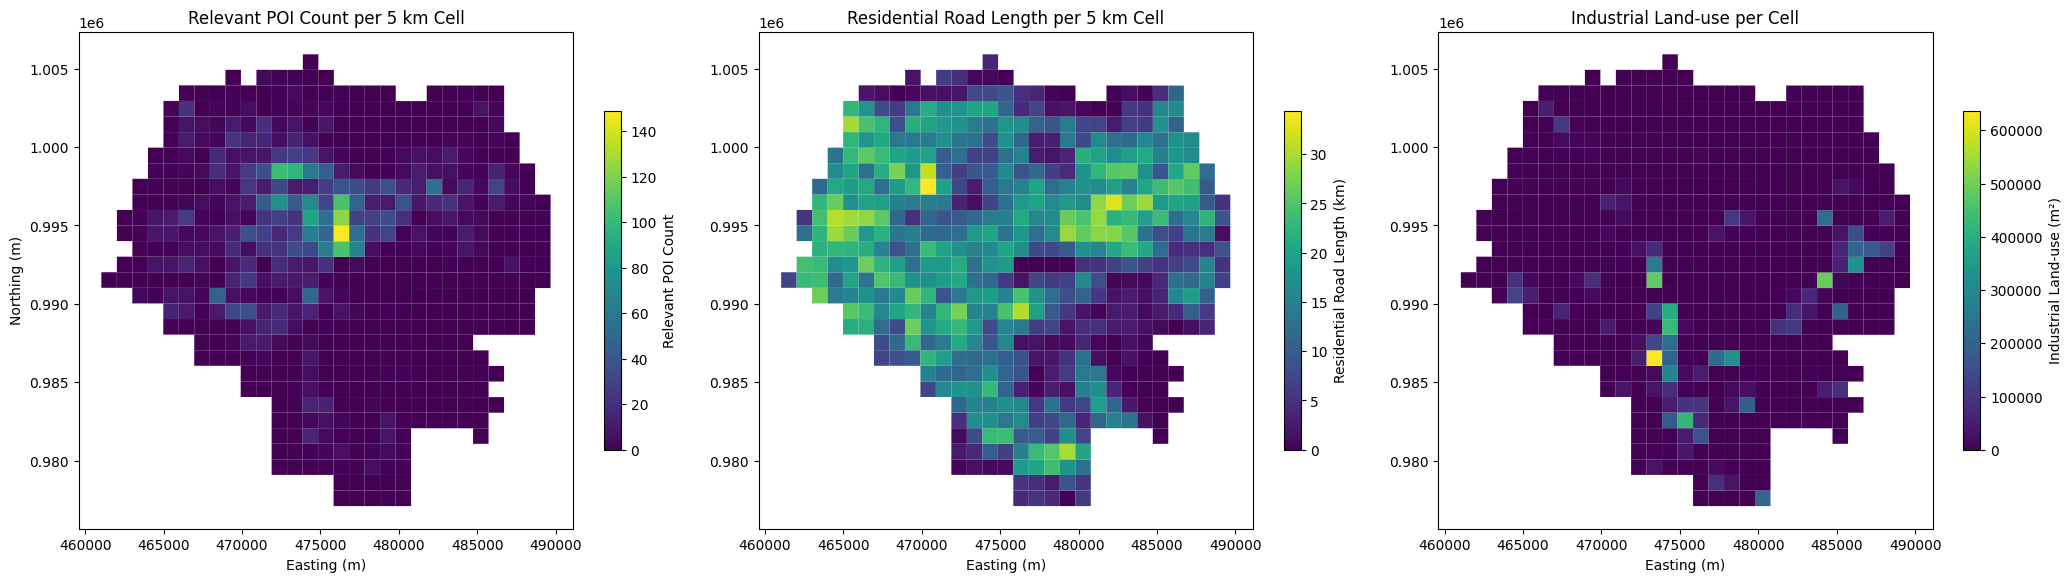

In [ ]:
# ## 8. QC / Logging & Summary Plots
print(f"Mesh cells: {len(mesh_sel)}")
print(f"Relevant POI fields: {len(relevant_poi)}")
print(f"Relevant Road fields: {len(relevant_road)}")
print(f"New columns added: {len(mesh_sel.columns) - len(mesh.columns)}")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))

# 1 - POI
mesh_sel.plot(
    column="poi_rel_count", ax=ax1, legend=True,
    legend_kwds={"label": "Relevant POI Count", "shrink": 0.6}
)
ax1.set_title("Relevant POI Count per 5 km Cell")
ax1.set_xlabel("Easting (m)")
ax1.set_ylabel("Northing (m)")

# 2 - Road (Residential km)
mesh_sel.plot(
    column="residential_km", ax=ax2, legend=True,
    legend_kwds={"label": "Residential Road Length (km)", "shrink": 0.6}
)
ax2.set_title("Residential Road Length per 5 km Cell")
ax2.set_xlabel("Easting (m)")
ax2.set_ylabel("")

# 3 - Land-use (industrial area)
if "industrial_m2" in mesh_sel.columns:
    mesh_sel.plot(
        column="industrial_m2", ax=ax3, legend=True,
        legend_kwds={"label": "Industrial Land-use (m²)", "shrink": 0.6}
    )
    ax3.set_title("Industrial Land-use per Cell")
else:
    ax3.set_axis_off()
    ax3.set_title("industrial_m2 column not found")

ax3.set_xlabel("Easting (m)")

plt.tight_layout()
plt.show()

Explore fclasses of POI and Road in order to save the appropiate

In [ ]:
# import os
# import geopandas as gpd

# # Adjust these paths if your outputs live elsewhere
# base_dir = r"C:\Users\Luis.ParraMorales\OneDrive - Imperial College London\Group Design Project"
# processed_dir = os.path.join(base_dir, "processed", "addis_ababa")

# # Load clipped datasets
# pois = gpd.read_file(os.path.join(processed_dir, "addis_ababa_pois_clip.gpkg"))
# roads = gpd.read_file(os.path.join(processed_dir, "addis_ababa_roads_clip.gpkg"))

# # POI classes and counts
# poi_counts = pois["fclass"].value_counts()
# print("=== POI classes ===")
# print(poi_counts.to_string())

In [ ]:
# # Road classes and counts
# road_counts = roads["fclass"].value_counts()
# print("\n=== Road classes ===")
# print(road_counts.to_string())

In [ ]:
# poi_counts.to_csv("pois_values.csv",index=True)
# road_counts.to_csv("road_values.csv",index=True)

#### City: Baghdad

#### 9) Paths & Parameters for Baghdad

In [ ]:
# ## Baghdad POI & Road-to-Mesh Pre-Processing (Relevant-Only, UTM 38 N)

# ### 9.1 Paths & Parameters for Baghdad

# Reuse relevant_poi, relevant_road from above
# Set up logging if not already
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

base_dir = r"C:\Users\Luis.ParraMorales\OneDrive - Imperial College London\Group Design Project"
paths_bg = {
    "boundary": os.path.join(base_dir, r"Boundary_Mesh\baghdad_boundary.geojson"),
    "mesh": os.path.join(base_dir, r"Boundary_Mesh\grid_badhdad.gpkg"),
    "pois":     os.path.join(base_dir, r"iraq-latest-free.shp\gis_osm_pois_free_1.shp"),
    "roads":    os.path.join(base_dir, r"iraq-latest-free.shp\gis_osm_roads_free_1.shp"),
    "land_use" : os.path.join(base_dir,r"iraq-latest-free.shp\gis_osm_landuse_a_free_1.shp")
}
out_dir_bg = os.path.join(base_dir, "processed", "baghdad")
os.makedirs(out_dir_bg, exist_ok=True)

target_crs_bg = "EPSG:32638"  # UTM Zone 38 N for Baghdad

# Reuse helper functions from above:
#   write_clip(gdf, name)  
#   write_enriched(gdf, name)
# and the lists relevant_poi, relevant_road

In [ ]:
# ### 9.2 Read & Reproject Mesh
mesh_bg = gpd.read_file(paths_bg["mesh"])
logging.info(f"Baghdad mesh CRS before: {mesh_bg.crs}")
mesh_bg = mesh_bg.to_crs(target_crs_bg)

# Ensure a GRID_ID column exists
if "GRID_ID" not in mesh_bg.columns:
    id_col_bg = "fid" if "fid" in mesh_bg.columns else "geom_id"
    mesh_bg["GRID_ID"] = mesh_bg[id_col_bg].astype(str)

# Build clipping masks (UTM for analysis, WGS84 for clip)
mesh_union_bg    = mesh_bg.unary_union
mesh_union_bg_ll = mesh_bg.to_crs("EPSG:4326").unary_union


INFO: Baghdad mesh CRS before: EPSG:4326
C:\Users\Luis.ParraMorales\AppData\Local\Temp\ipykernel_9700\3568339437.py:12: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mesh_union_bg    = mesh_bg.unary_union
C:\Users\Luis.ParraMorales\AppData\Local\Temp\ipykernel_9700\3568339437.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mesh_union_bg_ll = mesh_bg.to_crs("EPSG:4326").unary_union


In [ ]:
# ### 9.3 Clip National POI & Road Layers
# %% 9.3 Clip National Layers to Baghdad Grid
pois_bg = (
    gpd.read_file(paths_bg["pois"], mask=mesh_union_bg_ll)
       .to_crs(target_crs_bg)
)
logging.info(f"Clipped Baghdad POIs: {len(pois_bg)}")

roads_bg = (
    gpd.read_file(paths_bg["roads"], mask=mesh_union_bg_ll)
       .to_crs(target_crs_bg)
)
logging.info(f"Clipped Baghdad Roads: {len(roads_bg)}")

landuse_bg = (
    gpd.read_file(paths_bg["land_use"], mask=mesh_union_bg_ll)
       .to_crs(target_crs_bg)
)
logging.info(f"Clipped Baghdad Land Use: {len(landuse_bg)}")

write_clip(pois_bg,  "baghdad_pois_clip")
write_clip(roads_bg, "baghdad_roads_clip")
write_clip(landuse_bg, "baghdad_landuse_clip")


INFO: Clipped Baghdad POIs: 16729
INFO: Clipped Baghdad Roads: 82260
INFO: Clipped Baghdad Land Use: 5948
INFO: Created 16,729 records
INFO: Created 16,729 records
INFO: Created 16,729 records
INFO: Wrote clipped baghdad_pois_clip
INFO: Created 82,260 records
INFO: Created 82,260 records
INFO: Created 82,260 records
INFO: Wrote clipped baghdad_roads_clip
INFO: Created 5,948 records
INFO: Created 5,948 records
INFO: Created 5,948 records
INFO: Wrote clipped baghdad_landuse_clip


In [ ]:
# %% 9.4 Enrich Baghdad Mesh with Relevant POI Counts
sjoin_poi_bg = gpd.sjoin(
    pois_bg,
    mesh_bg[["GRID_ID", "geometry"]],
    predicate="within", how="inner"
)[["GRID_ID", "fclass"]]

poic_bg    = sjoin_poi_bg.groupby(["GRID_ID","fclass"]).size().reset_index(name="count")
poi_all_bg = poic_bg.groupby("GRID_ID")["count"].sum().rename("poi_all_count")
poic_rel_bg= poic_bg[poic_bg["fclass"].isin(relevant_poi)]
poi_wide_bg= poic_rel_bg.pivot(index="GRID_ID", columns="fclass", values="count").fillna(0)

# Start enrichment on a fresh copy indexed by GRID_ID
mesh_bg_sel = mesh_bg.set_index("GRID_ID").copy()
for cls in relevant_poi:
    mesh_bg_sel[f"{cls}_c"] = poi_wide_bg.get(cls, pd.Series(0))\
        .reindex(mesh_bg_sel.index, fill_value=0)

mesh_bg_sel["poi_rel_count"]   = mesh_bg_sel[[f"{c}_c" for c in relevant_poi]].sum(axis=1)
mesh_bg_sel["poi_all_count"]   = poi_all_bg.reindex(mesh_bg_sel.index, fill_value=0)
mesh_bg_sel["poi_other_count"] = mesh_bg_sel["poi_all_count"] - mesh_bg_sel["poi_rel_count"]

logging.info("Baghdad POI enrichment complete.")


INFO: Baghdad POI enrichment complete.


In [ ]:
# %% 9.5 Enrich Baghdad Mesh with Relevant Road Lengths
roads_bg["seg_km"] = roads_bg.geometry.length / 1000.0

sjoin_rd_bg = gpd.sjoin(
    roads_bg[["fclass","seg_km","geometry"]],
    mesh_bg[["GRID_ID","geometry"]],
    predicate="intersects", how="inner"
)[["GRID_ID","fclass","seg_km"]]

roadc_bg     = sjoin_rd_bg.groupby(["GRID_ID","fclass"])["seg_km"].sum().reset_index()
road_all_bg  = roadc_bg.groupby("GRID_ID")["seg_km"].sum().rename("road_all_km")
road_rel_bg  = roadc_bg[roadc_bg["fclass"].isin(relevant_road)]
road_wide_bg = road_rel_bg.pivot(index="GRID_ID", columns="fclass", values="seg_km").fillna(0)

for cls in relevant_road:
    mesh_bg_sel[f"{cls}_km"] = road_wide_bg.get(cls, pd.Series(0))\
        .reindex(mesh_bg_sel.index, fill_value=0)

mesh_bg_sel["road_rel_km"]   = mesh_bg_sel[[f"{c}_km" for c in relevant_road]].sum(axis=1)
mesh_bg_sel["road_all_km"]   = road_all_bg.reindex(mesh_bg_sel.index, fill_value=0)
mesh_bg_sel["road_other_km"] = mesh_bg_sel["road_all_km"] - mesh_bg_sel["road_rel_km"]

logging.info("Baghdad road enrichment complete.")

mesh_bg_sel = mesh_bg_sel.reset_index()

INFO: Baghdad road enrichment complete.


In [ ]:
# %% 9.5 bis) Enrich Baghdad Mesh with Land-Use Areas ────────────────────────
# 9.5.1  Fix invalid geometries
landuse_bg_valid = landuse_bg.copy()
landuse_bg_valid["geometry"] = landuse_bg_valid.geometry.buffer(0)

# 9.5.2  Intersect land-use polygons with the mesh
inter_bg = gpd.overlay(
    mesh_bg_sel[["GRID_ID", "geometry"]],
    landuse_bg_valid[["fclass", "geometry"]],
    how="intersection"
)
print(f"Intersected Baghdad land-use polygons: {len(inter_bg)}")

# 9.5.3  Compute area (m²)
inter_bg["lu_area_m2"] = inter_bg.geometry.area

# 9.5.4  Aggregate & pivot wide
lu_sum_bg = (
    inter_bg
    .groupby(["GRID_ID", "fclass"])["lu_area_m2"]
    .sum()
    .reset_index()
)
lu_wide_bg = (
    lu_sum_bg
    .pivot_table(
        index="GRID_ID",
        columns="fclass",
        values="lu_area_m2",
        aggfunc="sum"
    )
    .fillna(0)
)

# 9.5.5  Build safe 10-char field names
safe_map_bg = {
    cls: cls.lower().replace("/", "_").replace(" ", "_")[:10] + "_m2"
    for cls in lu_wide_bg.columns
}
lu_wide_bg.rename(columns=safe_map_bg, inplace=True)
safe_cols_bg = list(safe_map_bg.values())

# 9.5.6  Merge back onto the grid
mesh_bg_sel = mesh_bg_sel.merge(
    lu_wide_bg.reset_index()[["GRID_ID"] + safe_cols_bg],
    on="GRID_ID", how="left"
)

# 9.5.7  Fill missing with 0 & compute total
for col in safe_cols_bg:
    mesh_bg_sel[col] = mesh_bg_sel[col].fillna(0)
mesh_bg_sel["land_all_m2"] = mesh_bg_sel[safe_cols_bg].sum(axis=1)

logging.info("Baghdad land-use enrichment complete.")

INFO: Baghdad land-use enrichment complete.


Intersected Baghdad land-use polygons: 10786


In [ ]:
# %% 9.6 Write Enriched Baghdad Meshes
# ------------------------------------

# 9.6.1 POI + Road enriched mesh
write_enriched(
    mesh_bg_sel,
    "baghdad_mesh_poi_road",
    folder=out_dir_bg
)

# 9.6.2 Land-use-only mesh
base_land_cols_bg = [c for c in mesh_bg_sel.columns if c.endswith("_m2")]
land_cols_bg = list(dict.fromkeys(base_land_cols_bg + ["land_all_m2"]))
land_cols_bg = ["GRID_ID"] + land_cols_bg + ["geometry"]

write_enriched(
    mesh_bg_sel[land_cols_bg],
    "baghdad_mesh_landuse",
    folder=out_dir_bg
)

INFO: Created 6,126 records
INFO: Created 6,126 records
INFO: Wrote baghdad_mesh_poi_road (gpkg + geojson)
INFO: Created 6,126 records
INFO: Created 6,126 records
INFO: Wrote baghdad_mesh_landuse (gpkg + geojson)


### Visualization for Baghdad

Baghdad mesh cells: 6126
Relevant POI fields: 61
Relevant Road fields: 9
New columns added: 94


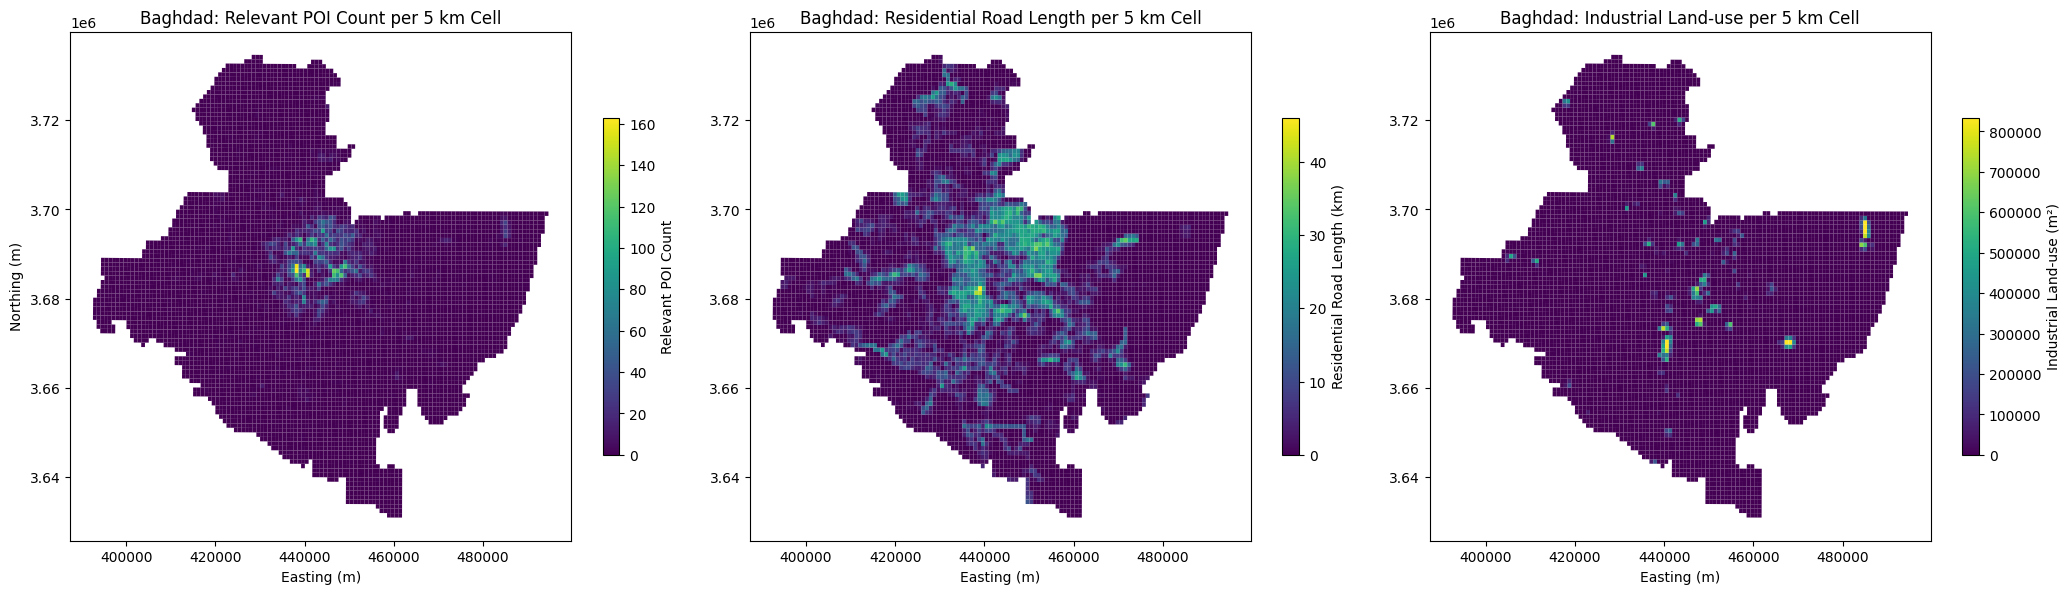

In [ ]:
# %% 9.7 QC & Visualization for Baghdad
# --------------------------------------

print(f"Baghdad mesh cells: {len(mesh_bg_sel)}")
print(f"Relevant POI fields: {len(relevant_poi)}")
print(f"Relevant Road fields: {len(relevant_road)}")
print(f"New columns added: {len(mesh_bg_sel.columns) - len(mesh_bg.columns)}")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))

# 1 – POI count
mesh_bg_sel.plot(
    column="poi_rel_count", ax=ax1, legend=True,
    legend_kwds={"label": "Relevant POI Count", "shrink": 0.6}
)
ax1.set_title("Baghdad: Relevant POI Count per 5 km Cell")
ax1.set_xlabel("Easting (m)")
ax1.set_ylabel("Northing (m)")

# 2 – Residential road length
mesh_bg_sel.plot(
    column="residential_km", ax=ax2, legend=True,
    legend_kwds={"label": "Residential Road Length (km)", "shrink": 0.6}
)
ax2.set_title("Baghdad: Residential Road Length per 5 km Cell")
ax2.set_xlabel("Easting (m)")
ax2.set_ylabel("")

# 3 – Industrial land-use area
mesh_bg_sel.plot(
    column="industrial_m2", ax=ax3, legend=True,
    legend_kwds={"label": "Industrial Land-use (m²)", "shrink": 0.6}
)
ax3.set_title("Baghdad: Industrial Land-use per 5 km Cell")
ax3.set_xlabel("Easting (m)")

plt.tight_layout()
plt.show()

## 2 Population Data

### 2.1 Custom Fuctions

In [3]:
# import geopandas as gpd
# from rasterstats import zonal_stats
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# import rasterio
# from pathlib import Path

# # Global Paths
# demo_dir = Path(r'D:/Projects/MSc_Group_Project/no2_economicactivity_gdp/demo-data')
# data_dir = Path(r'C:/Users/26454/OneDrive - Imperial College London/Desktop/group design project/Data/World population')


In [3]:
addis_meshes_path = data_root / 'addis-mesh-data'
baghdad_meshes_path = data_root / 'baghdad-mesh-data'

mesh_addis = data_root / "mesh-grid" / "grid_addis_ababa.gpkg"
mesh_baghdad = data_root / "mesh-grid" / "grid_baghdad.gpkg"

lyr_addis_name = fiona.listlayers(mesh_addis)[0]         # control layer number = 1 
lyr_baghdad_name = fiona.listlayers(mesh_baghdad)[0]

### 2.2 Aggregate Based on Mesh Grid & Visualization

#### Ethiopia - Addis Ababa

In [4]:
output_root = data_root / "eth-pop-gpkg"          # path for saving the data
eth_pop_path = data_root / 'eth-pop'

aggregate_pop_data(
    data_tiff_path=eth_pop_path,
    mesh_path=mesh_addis,
    layer_name=lyr_addis_name,
    agg_type="sum",
    feature_col="pop_sum_m",
    output_path=output_root
)

Currently working on: 1/2, Year: 2023
Saved: C:\Users\26454\OneDrive - Imperial College London\Documents\GitHub\air-pollution-mobility-research-project\data\eth-pop-gpkg\pop_aggregated_2023.gpkg
Currently working on: 2/2, Year: 2024
Saved: C:\Users\26454\OneDrive - Imperial College London\Documents\GitHub\air-pollution-mobility-research-project\data\eth-pop-gpkg\pop_aggregated_2024.gpkg


In [5]:
eth_2023 = gpd.read_file(data_root / "eth-pop-gpkg" / "pop_aggregated_2023.gpkg")
eth_2024 = gpd.read_file(data_root / "eth-pop-gpkg" / "pop_aggregated_2024.gpkg")
#eth_2023
#eth_2024

In [6]:
# Filter for .gpkg files that contain "2023" in the filename
gpkg_files_2023_eth = [f for f in addis_meshes_path.glob("*.gpkg") if "2023" in f.name]

# Print the count
print(f"There are {len(gpkg_files_2023_eth)} files from the year 2023.")

# Filter for .gpkg files that contain "2023" in the filename
gpkg_files_2024_eth = [f for f in addis_meshes_path.glob("*.gpkg") if "2024" in f.name]

# Print the count
print(f"There are {len(gpkg_files_2024_eth)} files from the year 2024.")

#print(len(list(addis_meshes_path.glob("*.gpkg"))))


There are 365 files from the year 2023.
There are 366 files from the year 2024.


In [7]:
# Input file paths
src_2023_eth = data_root / "eth-pop-gpkg" / "pop_aggregated_2023.gpkg"
src_2024_eth = data_root / "eth-pop-gpkg" / "pop_aggregated_2024.gpkg"

# Output directory 
output_path = data_root

# Run for 2023 and 2024
generate_daily_files(src_2023_eth, 2023, 365, "addis-ababa", output_path)
generate_daily_files(src_2024_eth, 2024, 366, "addis-ababa", output_path)


Done: 365 files created for 2023.
Done: 366 files created for 2024.


In [8]:
#len(list(output_dir.glob("*.gpkg")))

In [9]:
pop_2023_eth = gpd.read_file(data_root / "pop-files-addis-ababa" / "addis-ababa-2023-02-21.gpkg")
pop_2024_eth = gpd.read_file(data_root / "pop-files-addis-ababa" / "addis-ababa-2024-02-21.gpkg")
#pop_2023_eth
#pop_2024_eth

#### Visualization

Demonstrate Addis Ababa population mesh in 2023 and 2024.

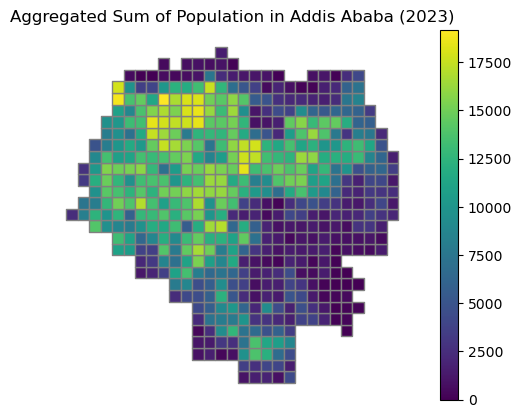

In [10]:
# visual
pop_2023_eth.plot(column="pop_sum_m", edgecolor="grey", legend=True)
plt.title("Aggregated Sum of Population in Addis Ababa (2023)")
plt.axis("off")
plt.show()

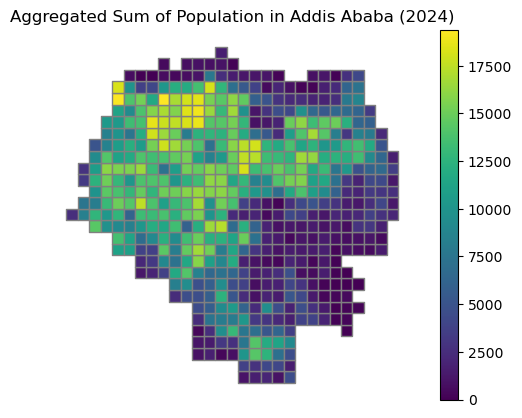

In [11]:
# visual
pop_2024_eth.plot(column="pop_sum_m", edgecolor="grey", legend=True)
plt.title("Aggregated Sum of Population in Addis Ababa (2024)")
plt.axis("off")
plt.show()

#### Iraq - Baghdad

In [12]:
output_root = data_root / "iraq-pop-gpkg"          # path for saving the data
iraq_pop_path = data_root / 'iraq-pop'

aggregate_pop_data(
    data_tiff_path=iraq_pop_path,
    mesh_path=mesh_baghdad,
    layer_name=lyr_baghdad_name,
    agg_type="sum",
    feature_col="pop_sum_m",
    output_path=output_root
)

Currently working on: 1/2, Year: 2023
Saved: C:\Users\26454\OneDrive - Imperial College London\Documents\GitHub\air-pollution-mobility-research-project\data\iraq-pop-gpkg\pop_aggregated_2023.gpkg
Currently working on: 2/2, Year: 2024
Saved: C:\Users\26454\OneDrive - Imperial College London\Documents\GitHub\air-pollution-mobility-research-project\data\iraq-pop-gpkg\pop_aggregated_2024.gpkg


In [13]:
iraq_2023 = gpd.read_file(data_root / "iraq-pop-gpkg" / "pop_aggregated_2023.gpkg")
iraq_2024 = gpd.read_file(data_root / "iraq-pop-gpkg" / "pop_aggregated_2024.gpkg")
#iraq_2023
#iraq_2024

In [14]:
# Filter for .gpkg files that contain "2023" in the filename
gpkg_files_2023_iraq = [f for f in baghdad_meshes_path.glob("*.gpkg") if "2023" in f.name]

# Print the count
print(f"There are {len(gpkg_files_2023_iraq)} files from the year 2023.")

# Filter for .gpkg files that contain "2023" in the filename
gpkg_files_2024_iraq = [f for f in baghdad_meshes_path.glob("*.gpkg") if "2024" in f.name]

# Print the count
print(f"There are {len(gpkg_files_2024_iraq)} files from the year 2024.")

#print(len(list(baghdad_meshes_path.glob("*.gpkg"))))

There are 365 files from the year 2023.
There are 366 files from the year 2024.


In [15]:
# Input file paths
src_2023_iraq = data_root / "iraq-pop-gpkg" / "pop_aggregated_2023.gpkg"
src_2024_iraq = data_root / "iraq-pop-gpkg" / "pop_aggregated_2024.gpkg"

# Output directory 
output_path = data_root 

# Run for 2023 and 2024
generate_daily_files(src_2023_iraq, 2023, 365, "baghdad", output_path)
generate_daily_files(src_2024_iraq, 2024, 366, "baghdad", output_path)

Done: 365 files created for 2023.
Done: 366 files created for 2024.


In [16]:
#len(list(output_dir.glob("*.gpkg")))

In [17]:
pop_2023_iraq = gpd.read_file(data_root / "pop-files-baghdad" / "baghdad-2023-02-21.gpkg")
pop_2024_iraq = gpd.read_file(data_root / "pop-files-baghdad" / "baghdad-2024-02-21.gpkg")
#pop_2023_iraq
#pop_2024_iraq

#### Visualization

Demonstrate Baghdad population mesh in 2023 and 2024.

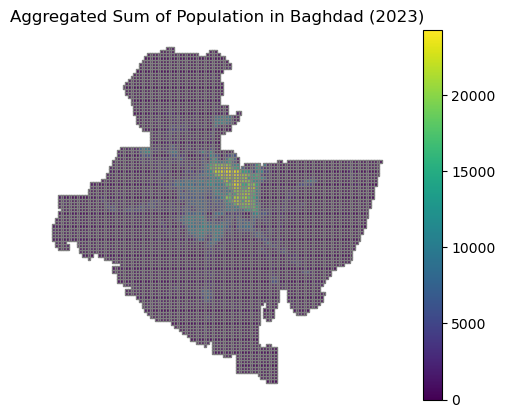

In [18]:
# visual
pop_2023_iraq.plot(column="pop_sum_m", cmap="viridis", edgecolor="grey", legend=True)
plt.title("Aggregated Sum of Population in Baghdad (2023)")
plt.axis("off")
plt.show()

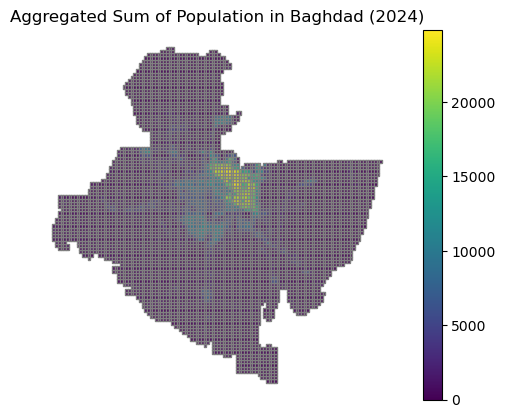

In [19]:
# visual
pop_2024_iraq.plot(column="pop_sum_m", cmap="viridis", edgecolor="grey", legend=True)
plt.title("Aggregated Sum of Population in Baghdad (2024)")
plt.axis("off")
plt.show()

## 3 Fire Data

### 3.1 Prepare Packages

In [ ]:
import numpy as np
import geopandas as gpd
from rasterstats import zonal_stats
import pyarrow
import pandas as pd
import matplotlib.pyplot as plt

### 3.2 Aggregate Fire Event Data

In [ ]:
# Step 1: load 5km mesh
mesh = gpd.read_file("/Users/JiaSyuan/Desktop/Group 1 Design Project/Code/baghdad_mesh_5km_JS.geojson")
mesh = mesh.to_crs("EPSG:4326") 

# Step 2: Specify the fire raster file
raster_path = "/Users/JiaSyuan/Downloads/FireMask_20220325.tif"

# Step 3: Perform zonal statistics aggregation
# Fire pixel values: 7 (high confidence), 8 (nominal), 9 (low)
# Only count pixels fully contained in each polygon
stats = zonal_stats(
    mesh, raster_path,
    stats="count",
    nodata=0,
    raster_out=False,
    categorical=True,
    all_touched=False  
)

# Step 4: Integrate zonal stats results into the mesh
mesh["fire_high_conf"] = [s.get(7, 0) for s in stats]  # Count of high confidence fire pixels (value 7)
mesh["fire_nom_conf"] = [s.get(8, 0) for s in stats]  # Count of nominal confidence fire pixels (value 8)
mesh["fire_low_conf"] = [s.get(9, 0) for s in stats]  # Count of low confidence fire pixels (value 9)
mesh["fire_total"] = mesh[["fire_high_conf", "fire_nom_conf", "fire_low_conf"]].sum(axis=1) # Total fire pixel count (sum of all confidence levels)

# Step 5: Export to .gpq or .csv format
output_path = "/Users/JiaSyuan/Desktop/Group 1 Design Project/Code/fire_agg_baghdad_2022177.gpq"
mesh.to_parquet(output_path)

print("Output：", output_path)


Output： /Users/JiaSyuan/Desktop/Group 1 Design Project/Code/fire_agg_baghdad_2022177.gpq


### 3.3 Visualization

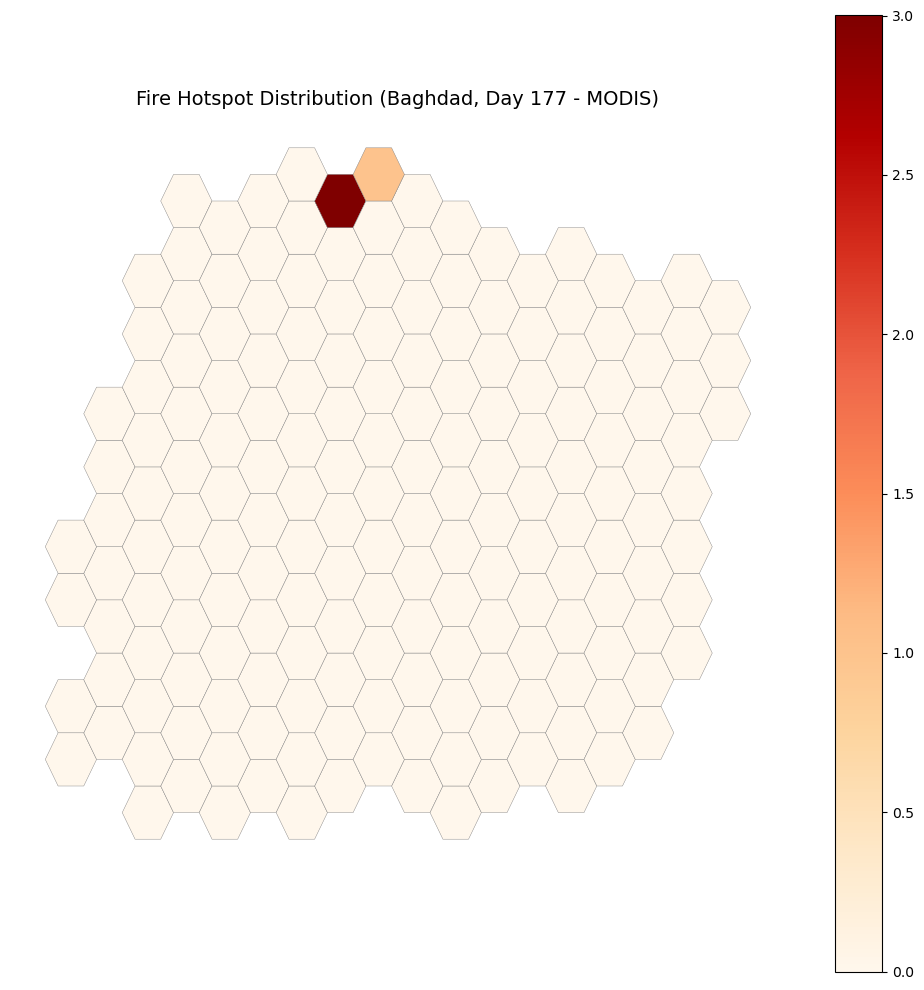

In [ ]:
# Load the aggregated result (including mesh geometry)
mesh = gpd.read_parquet("/Users/JiaSyuan/Desktop/Group 1 Design Project/Code/fire_agg_baghdad_2022177.gpq")

# Plot: color the mesh based on total fire count (fire_total)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
mesh.plot(
    column="fire_total",
    cmap="OrRd",          # Orange-red colormap, mimicking a heatmap
    linewidth=0.3,
    edgecolor="grey",
    legend=True,
    ax=ax
)

ax.set_title("Fire Hotspot Distribution (Baghdad, Day 177 - MODIS)", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

print("Total number of fire pixels in the area:", mesh["fire_total"].sum())
print("Number of hexagons with fire pixels:", (mesh["fire_total"] > 0).sum())